# Evaluation of Graph Neural Network segment classifier

In [1]:
%pwd

'/global/u2/s/sfarrell/WorkAreas/trackml/heptrkx-gnn-tracking/notebooks'

In [2]:
# System imports
import os
import sys
import pprint

# External imports
import matplotlib.pyplot as plt
import numpy as np

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from nb_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics, draw_sample_xy)

In [3]:
%matplotlib inline

## Load training results

Specify which results to load either by config file or training output directory.

In [4]:
# Load by directory (preferred)
result_base = os.path.expandvars('$SCRATCH/heptrkx/results')

In [5]:
ls $result_base

RNNFilter_20180207_1121/  gnnsegclf_small_000/  resepnn_big_001/
agnn_000/                 gnnsegclf_small_001/  resepnn_big_003/
agnn_001/                 gnnsegclf_small_002/  resmpnn_001/
agnn_002/                 gnnsparse_big_001/    resmpnn_002/
agnn_002_8gpu/            gnnsparse_med_001/    resmpnn_002a/
agnn_003/                 hello/                resmpnn_002b/
agnn_big_000/             mpnn_001/             resmpnn_002c/
agnn_big_001/             mpnn_002/             resmpnn_002d/
agnn_big_002/             mpnn_batch/           resmpnn_003/
agnn_scaling/             mpnn_big_000/         resmpnn_big_000/
gnnsegclf_000/            mpnn_big_001/         resmpnn_big_001/
gnnsegclf_001/            mpnn_big_002/         resmpnn_big_002/
gnnsegclf_004/            mpnn_big_003/         resmpnn_big_003/
gnnsegclf_big_000/        mpnn_big_004/         resmpnn_filt/
gnnsegclf_big_002/        mpnn_big_005/         resmpnn_nomom/
gnnsegclf_big_003/        mpnn_big_006/         resmpn

In [6]:
result_name = 'agnn_001'
result_dir = os.path.join(result_base, result_name)

config = load_config_dir(result_dir)
print('Configuration:')
pprint.pprint(config)

summaries = load_summaries(config)
print('\nTraining summaries:')
summaries

Configuration:
{'data': {'batch_size': 4,
          'input_dir': '${SCRATCH}/heptrkx/data/hitgraphs_high_000',
          'n_train': 49152,
          'n_valid': 4096,
          'n_workers': 4,
          'name': 'hitgraphs_sparse',
          'real_weight': 5},
 'model': {'hidden_dim': 64,
           'input_dim': 3,
           'layer_norm': True,
           'loss_func': 'binary_cross_entropy_with_logits',
           'n_graph_iters': 8,
           'name': 'agnn'},
 'optimizer': {'learning_rate': 0.001,
               'lr_decay_schedule': [{'end_epoch': 32,
                                      'factor': 0.1,
                                      'start_epoch': 16},
                                     {'end_epoch': 64,
                                      'factor': 0.01,
                                      'start_epoch': 32}],
               'lr_scaling': 'sqrt',
               'lr_warmup_epochs': 5,
               'name': 'Adam'},
 'output_dir': '/global/cscratch1/sd/sfarrell/heptrkx/r

lr  train_loss  epoch   train_time  valid_loss  valid_acc  valid_time
0   0.00100    0.311542      0  1494.670187    0.169248   0.925674   58.839868
1   0.00100    0.138564      1  1488.510759    0.085495   0.969584   57.275952
2   0.00100    0.088346      2  1488.456320    0.070017   0.976182   57.918634
3   0.00100    0.076166      3  1488.227625    0.062344   0.979294   56.906239
4   0.00100    0.067371      4  1488.159731    0.058193   0.981448   57.926392
..      ...         ...    ...          ...         ...        ...         ...
59  0.00001    0.044199     59  1493.079353    0.036775   0.989571   58.199682
60  0.00001    0.044191     60  1488.814085    0.036241   0.989708   58.785429
61  0.00001    0.044186     61  1489.192389    0.036985   0.989443   58.373909
62  0.00001    0.044162     62  1489.491866    0.036389   0.989670   57.718011
63  0.00001    0.044164     63  1488.837783    0.035579   0.989925   57.580536

[64 rows x 7 columns]

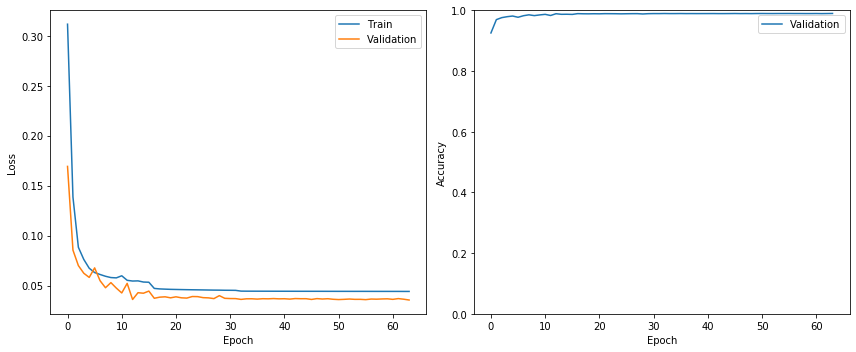

In [7]:
plot_train_history(summaries)

Text(0, 0.5, 'Learning rate')

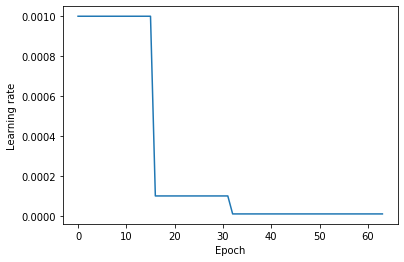

In [8]:
# Plot the learning rate
plt.figure()
plt.plot(summaries.lr)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')

## Load the trained model

In [9]:
# Find the best epoch
best_idx = summaries.valid_loss.idxmin()
summaries.loc[[best_idx]]

lr  train_loss  epoch   train_time  valid_loss  valid_acc  valid_time
63  0.00001    0.044164     63  1488.837783    0.035579   0.989925   57.580536

In [10]:
# Build the trainer and load best checkpoint
trainer = get_trainer(output_dir=config['output_dir'], **config['trainer'])
trainer.build_model(optimizer_config=config['optimizer'], **config['model'])

best_epoch = summaries.epoch.loc[best_idx]
trainer.load_checkpoint(checkpoint_id=best_epoch)

print(trainer.model)
print('Parameters:', sum(p.numel() for p in trainer.model.parameters()))

GNNSegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=134, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (8): Tanh()
      (9): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=201, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_fea

## Evaluate the model on the test dataset

In [11]:
# Load the test dataset
n_test = 64
test_loader = get_test_data_loader(config, n_test=n_test)

In [12]:
%%time
# Apply the model
test_preds, test_targets = trainer.predict(test_loader)

CPU times: user 1min 17s, sys: 3.74 s, total: 1min 20s
Wall time: 20.6 s


In [13]:
threshold = 0.5
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.5
Accuracy:  0.9898
Precision: 0.8980
Recall:    0.9688


In [14]:
threshold = 0.8
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.8
Accuracy:  0.9938
Precision: 0.9610
Recall:    0.9520


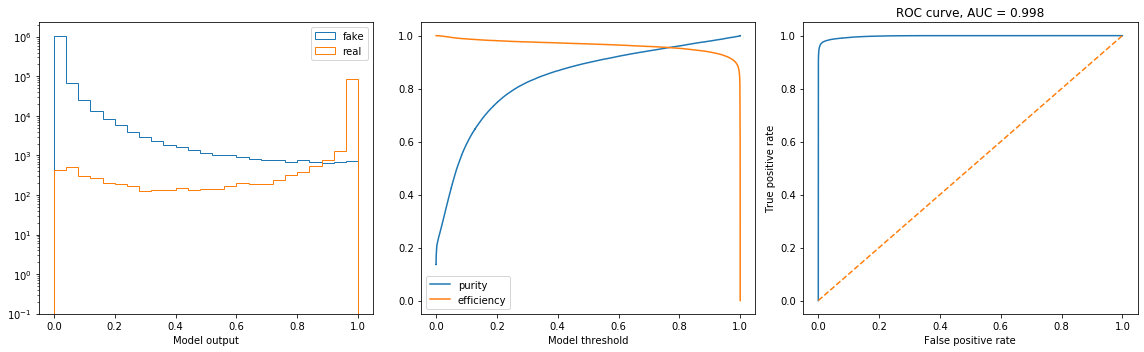

In [15]:
plot_metrics(test_preds, test_targets, test_metrics)

## Visualize predictions

In [16]:
n_phi_sections = 8
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000.])

In [17]:
i = 0

g = test_loader.dataset[i]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

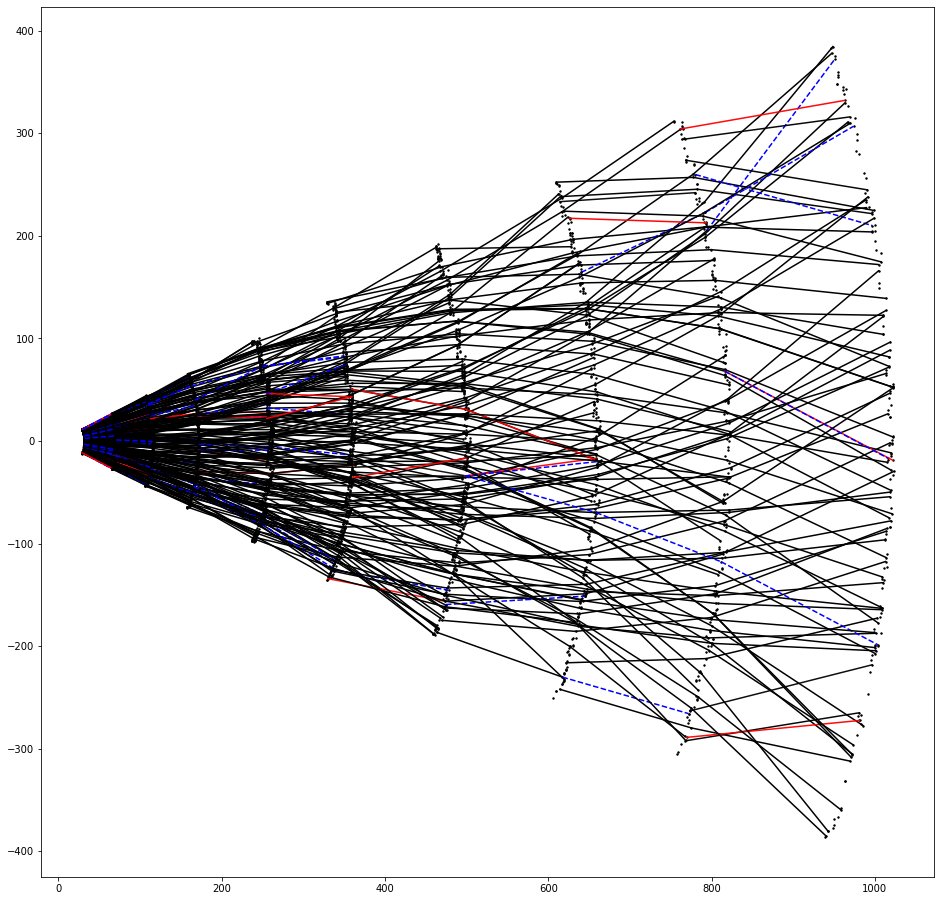

In [18]:
draw_sample_xy(x, e, o, y, cut=0.9);